In [128]:
#LIBRARIES

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import librosa.display
import IPython.display as ipd

from glob import glob #list all the files of a director

import pandas as pd
import numpy as np

#extras
import os
from sklearn.model_selection import train_test_split

import skimage.io

import resampy 

In [129]:
import warnings
warnings.filterwarnings("ignore")

In [130]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score, recall_score

#HYPERPARAMETERS 
from sklearn.model_selection import GridSearchCV

#BALANCING DATA
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE


In [131]:
# nice colours for plots
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## METADATA

In [132]:
import glob
import pandas as pd

audio_dataset_path = 'C:/Users/migue/Documents/IRONHACK/FINAL PROJECT/audio_data'

file_paths = glob.glob('C:/Users/migue/Documents/IRONHACK/FINAL PROJECT/audio_data/*/*')
data = {'file_name': [os.path.basename(file_path) for file_path in file_paths],
        'label': [os.path.basename(os.path.dirname(file_path)) for file_path in file_paths]}
audio_metadata = pd.DataFrame(data)
audio_metadata

,file_name,label
0,549a46d8-9c84-430e-ade8-97eae2bef787-143013077...,belly_pain
1,643D64AD-B711-469A-AF69-55C0D5D3E30F-143013849...,belly_pain
2,643D64AD-B711-469A-AF69-55C0D5D3E30F-143013850...,belly_pain
3,643D64AD-B711-469A-AF69-55C0D5D3E30F-143013851...,belly_pain
4,643D64AD-B711-469A-AF69-55C0D5D3E30F-143013852...,belly_pain
...,...,...
452,d5abedab-9ed5-48d0-a83b-fc00c33d6d6b-143007919...,tired
453,d6cda191-4962-4308-9a36-46d5648a95ed-143158788...,tired
454,d6cda191-4962-4308-9a36-46d5648a95ed-143158789...,tired
455,d6cda191-4962-4308-9a36-46d5648a95ed-143161658...,tired


In [133]:
# check for imbalanced dataset:

audio_metadata.label.value_counts()

hungry        382
discomfort     27
tired          24
belly_pain     16
burping         8
Name: label, dtype: int64

<AxesSubplot: >

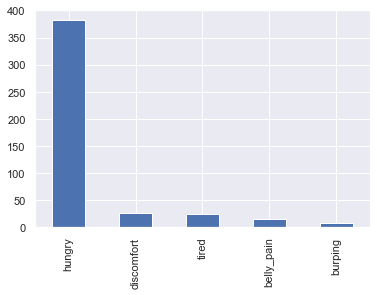

In [134]:
sns.set()
audio_metadata["label"].value_counts().plot(kind="bar")

## Extract features

Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [135]:
n_mfcc = 40

# mfccs = librosa.feature.mfcc(y=amplitudes, sr=sr, n_mfcc=n_mfcc)
# print(mfccs.shape)

In [136]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features
    

In [137]:
import numpy as np
from tqdm import tqdm #to see the progress of the interation

audio_dataset_path = 'C:/Users/migue/Documents/IRONHACK/FINAL PROJECT/audio_data/'

### Now we iterate through every audio file and extract features using Mel-Frequency Cepstral Coefficients
extracted_features=[]

for index_num,row in tqdm(audio_metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["label"])+'/',str(row["file_name"]))
    final_class_labels = row["label"]
    data = features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

457it [00:23, 19.75it/s]


In [138]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','label'])
extracted_features_df.head()

,feature,label
0,"[-499.4247, 112.08116, -49.807816, -18.21421, ...",belly_pain
1,"[-503.241, 155.62462, -53.089634, -9.338754, 1...",belly_pain
2,"[-426.70706, 157.33188, -52.70597, -14.5242, 1...",belly_pain
3,"[-389.0387, 168.44524, -67.22318, -17.126297, ...",belly_pain
4,"[-317.4329, 176.0357, -62.427364, -4.4671364, ...",belly_pain


In [139]:
# defining a function to extract columns from the 'feature' column:

audio_features = extracted_features_df.join(extracted_features_df['feature'].apply(lambda x: pd.Series(x)))
audio_features.drop('feature', axis=1, inplace=True)
audio_features.head()

,label,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,belly_pain,-499.424713,112.081161,-49.807816,-18.214211,13.028866,-26.151291,-14.420481,7.603708,-11.387850,...,-5.277434,-2.046124,3.276306,4.814387,1.566615,0.335952,1.693973,-0.683485,-4.242712,-2.821082
1,belly_pain,-503.240997,155.624619,-53.089634,-9.338754,18.954021,-30.361124,-10.490327,-0.191979,-25.778471,...,0.319254,-1.159282,-5.115259,-1.217770,0.125908,-1.005656,0.573103,1.187626,3.673102,5.454000
2,belly_pain,-426.707062,157.331879,-52.705971,-14.524200,11.352674,-37.552837,-15.138313,0.320166,-24.708115,...,-2.655442,-1.795501,-2.781284,-0.339015,-0.960696,-2.035474,-0.726631,-2.245474,-2.666178,-0.223122
3,belly_pain,-389.038696,168.445236,-67.223183,-17.126297,13.631199,-41.452286,-14.523580,-1.005277,-31.239029,...,2.359671,2.486675,0.891681,3.970485,1.110400,-1.227667,0.690895,-1.282442,-0.621609,2.109241
4,belly_pain,-317.432892,176.035706,-62.427364,-4.467136,17.833765,-48.702011,-19.136120,-3.011306,-32.136478,...,4.420218,2.126175,1.675153,5.267370,0.063184,-1.355639,2.513359,-0.295119,-0.607795,1.403075


### Reclassifying labels into hungry or not_hungry

In [140]:
audio_features[audio_features["label"]!= "hungry"]

,label,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,belly_pain,-499.424713,112.081161,-49.807816,-18.214211,13.028866,-26.151291,-14.420481,7.603708,-11.387850,...,-5.277434,-2.046124,3.276306,4.814387,1.566615,0.335952,1.693973,-0.683485,-4.242712,-2.821082
1,belly_pain,-503.240997,155.624619,-53.089634,-9.338754,18.954021,-30.361124,-10.490327,-0.191979,-25.778471,...,0.319254,-1.159282,-5.115259,-1.217770,0.125908,-1.005656,0.573103,1.187626,3.673102,5.454000
2,belly_pain,-426.707062,157.331879,-52.705971,-14.524200,11.352674,-37.552837,-15.138313,0.320166,-24.708115,...,-2.655442,-1.795501,-2.781284,-0.339015,-0.960696,-2.035474,-0.726631,-2.245474,-2.666178,-0.223122
3,belly_pain,-389.038696,168.445236,-67.223183,-17.126297,13.631199,-41.452286,-14.523580,-1.005277,-31.239029,...,2.359671,2.486675,0.891681,3.970485,1.110400,-1.227667,0.690895,-1.282442,-0.621609,2.109241
4,belly_pain,-317.432892,176.035706,-62.427364,-4.467136,17.833765,-48.702011,-19.136120,-3.011306,-32.136478,...,4.420218,2.126175,1.675153,5.267370,0.063184,-1.355639,2.513359,-0.295119,-0.607795,1.403075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,tired,-549.808960,87.620987,-52.848518,-4.859076,28.336473,-17.738258,-12.495114,6.238529,-11.197370,...,-3.109350,-1.398569,-2.175566,-1.936206,-1.360530,-2.762978,-1.880727,-0.471094,-2.064632,-2.353254
453,tired,-382.692291,63.694927,-67.268288,-28.363958,4.281721,-21.530396,-2.429851,15.150540,-4.196824,...,3.771558,-0.107505,-3.003051,-0.118598,-0.048766,-1.230707,1.305115,-0.617733,-4.682159,-1.702138
454,tired,-330.265472,100.000862,-100.228058,-40.944801,6.029012,-24.748707,1.218462,7.054237,-14.843027,...,4.943316,-0.336607,-5.245883,-0.964823,-0.118160,-0.378588,1.837693,0.252640,-0.431679,0.744630
455,tired,-335.744446,148.460281,-110.957558,-9.835780,20.750916,-59.526371,-2.249499,26.060947,-29.037586,...,1.341541,-1.030828,-3.885526,0.323580,0.752303,0.185139,1.064431,-0.196812,0.555770,1.545973


In [141]:
# Replace the label column with the new labels
audio_features.loc[audio_features["label"] != "hungry", "category"] = "not_hungry"
audio_features.loc[audio_features["label"] == "hungry", "category"] = "hungry"

audio_features

,label,0,1,2,3,4,5,6,7,8,...,31,32,33,34,35,36,37,38,39,category
0,belly_pain,-499.424713,112.081161,-49.807816,-18.214211,13.028866,-26.151291,-14.420481,7.603708,-11.387850,...,-2.046124,3.276306,4.814387,1.566615,0.335952,1.693973,-0.683485,-4.242712,-2.821082,not_hungry
1,belly_pain,-503.240997,155.624619,-53.089634,-9.338754,18.954021,-30.361124,-10.490327,-0.191979,-25.778471,...,-1.159282,-5.115259,-1.217770,0.125908,-1.005656,0.573103,1.187626,3.673102,5.454000,not_hungry
2,belly_pain,-426.707062,157.331879,-52.705971,-14.524200,11.352674,-37.552837,-15.138313,0.320166,-24.708115,...,-1.795501,-2.781284,-0.339015,-0.960696,-2.035474,-0.726631,-2.245474,-2.666178,-0.223122,not_hungry
3,belly_pain,-389.038696,168.445236,-67.223183,-17.126297,13.631199,-41.452286,-14.523580,-1.005277,-31.239029,...,2.486675,0.891681,3.970485,1.110400,-1.227667,0.690895,-1.282442,-0.621609,2.109241,not_hungry
4,belly_pain,-317.432892,176.035706,-62.427364,-4.467136,17.833765,-48.702011,-19.136120,-3.011306,-32.136478,...,2.126175,1.675153,5.267370,0.063184,-1.355639,2.513359,-0.295119,-0.607795,1.403075,not_hungry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,tired,-549.808960,87.620987,-52.848518,-4.859076,28.336473,-17.738258,-12.495114,6.238529,-11.197370,...,-1.398569,-2.175566,-1.936206,-1.360530,-2.762978,-1.880727,-0.471094,-2.064632,-2.353254,not_hungry
453,tired,-382.692291,63.694927,-67.268288,-28.363958,4.281721,-21.530396,-2.429851,15.150540,-4.196824,...,-0.107505,-3.003051,-0.118598,-0.048766,-1.230707,1.305115,-0.617733,-4.682159,-1.702138,not_hungry
454,tired,-330.265472,100.000862,-100.228058,-40.944801,6.029012,-24.748707,1.218462,7.054237,-14.843027,...,-0.336607,-5.245883,-0.964823,-0.118160,-0.378588,1.837693,0.252640,-0.431679,0.744630,not_hungry
455,tired,-335.744446,148.460281,-110.957558,-9.835780,20.750916,-59.526371,-2.249499,26.060947,-29.037586,...,-1.030828,-3.885526,0.323580,0.752303,0.185139,1.064431,-0.196812,0.555770,1.545973,not_hungry


In [142]:
audio_features_label = audio_features.copy()
audio_features_label.drop(columns = ["category"], inplace = True)
audio_features_label

,label,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,belly_pain,-499.424713,112.081161,-49.807816,-18.214211,13.028866,-26.151291,-14.420481,7.603708,-11.387850,...,-5.277434,-2.046124,3.276306,4.814387,1.566615,0.335952,1.693973,-0.683485,-4.242712,-2.821082
1,belly_pain,-503.240997,155.624619,-53.089634,-9.338754,18.954021,-30.361124,-10.490327,-0.191979,-25.778471,...,0.319254,-1.159282,-5.115259,-1.217770,0.125908,-1.005656,0.573103,1.187626,3.673102,5.454000
2,belly_pain,-426.707062,157.331879,-52.705971,-14.524200,11.352674,-37.552837,-15.138313,0.320166,-24.708115,...,-2.655442,-1.795501,-2.781284,-0.339015,-0.960696,-2.035474,-0.726631,-2.245474,-2.666178,-0.223122
3,belly_pain,-389.038696,168.445236,-67.223183,-17.126297,13.631199,-41.452286,-14.523580,-1.005277,-31.239029,...,2.359671,2.486675,0.891681,3.970485,1.110400,-1.227667,0.690895,-1.282442,-0.621609,2.109241
4,belly_pain,-317.432892,176.035706,-62.427364,-4.467136,17.833765,-48.702011,-19.136120,-3.011306,-32.136478,...,4.420218,2.126175,1.675153,5.267370,0.063184,-1.355639,2.513359,-0.295119,-0.607795,1.403075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,tired,-549.808960,87.620987,-52.848518,-4.859076,28.336473,-17.738258,-12.495114,6.238529,-11.197370,...,-3.109350,-1.398569,-2.175566,-1.936206,-1.360530,-2.762978,-1.880727,-0.471094,-2.064632,-2.353254
453,tired,-382.692291,63.694927,-67.268288,-28.363958,4.281721,-21.530396,-2.429851,15.150540,-4.196824,...,3.771558,-0.107505,-3.003051,-0.118598,-0.048766,-1.230707,1.305115,-0.617733,-4.682159,-1.702138
454,tired,-330.265472,100.000862,-100.228058,-40.944801,6.029012,-24.748707,1.218462,7.054237,-14.843027,...,4.943316,-0.336607,-5.245883,-0.964823,-0.118160,-0.378588,1.837693,0.252640,-0.431679,0.744630
455,tired,-335.744446,148.460281,-110.957558,-9.835780,20.750916,-59.526371,-2.249499,26.060947,-29.037586,...,1.341541,-1.030828,-3.885526,0.323580,0.752303,0.185139,1.064431,-0.196812,0.555770,1.545973


In [143]:
audio_features_nothungry = audio_features.copy()
audio_features_nothungry.drop(columns = ["label"], inplace = True)
audio_features_nothungry.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,category
0,-499.424713,112.081161,-49.807816,-18.214211,13.028866,-26.151291,-14.420481,7.603708,-11.387850,-9.128422,...,-2.046124,3.276306,4.814387,1.566615,0.335952,1.693973,-0.683485,-4.242712,-2.821082,not_hungry
1,-503.240997,155.624619,-53.089634,-9.338754,18.954021,-30.361124,-10.490327,-0.191979,-25.778471,-7.877410,...,-1.159282,-5.115259,-1.217770,0.125908,-1.005656,0.573103,1.187626,3.673102,5.454000,not_hungry
2,-426.707062,157.331879,-52.705971,-14.524200,11.352674,-37.552837,-15.138313,0.320166,-24.708115,-10.134473,...,-1.795501,-2.781284,-0.339015,-0.960696,-2.035474,-0.726631,-2.245474,-2.666178,-0.223122,not_hungry
3,-389.038696,168.445236,-67.223183,-17.126297,13.631199,-41.452286,-14.523580,-1.005277,-31.239029,-8.384931,...,2.486675,0.891681,3.970485,1.110400,-1.227667,0.690895,-1.282442,-0.621609,2.109241,not_hungry
4,-317.432892,176.035706,-62.427364,-4.467136,17.833765,-48.702011,-19.136120,-3.011306,-32.136478,-8.081997,...,2.126175,1.675153,5.267370,0.063184,-1.355639,2.513359,-0.295119,-0.607795,1.403075,not_hungry


In [144]:
audio_features_nothungry["category"].value_counts()

hungry        382
not_hungry     75
Name: category, dtype: int64

## Hungry vs Not hungry

In [145]:
### Split the dataset into independent and dependent dataset
x = audio_features_nothungry.drop('category', axis=1)
y = audio_features_nothungry['category']

In [146]:
x

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-499.424713,112.081161,-49.807816,-18.214211,13.028866,-26.151291,-14.420481,7.603708,-11.387850,-9.128422,...,-5.277434,-2.046124,3.276306,4.814387,1.566615,0.335952,1.693973,-0.683485,-4.242712,-2.821082
1,-503.240997,155.624619,-53.089634,-9.338754,18.954021,-30.361124,-10.490327,-0.191979,-25.778471,-7.877410,...,0.319254,-1.159282,-5.115259,-1.217770,0.125908,-1.005656,0.573103,1.187626,3.673102,5.454000
2,-426.707062,157.331879,-52.705971,-14.524200,11.352674,-37.552837,-15.138313,0.320166,-24.708115,-10.134473,...,-2.655442,-1.795501,-2.781284,-0.339015,-0.960696,-2.035474,-0.726631,-2.245474,-2.666178,-0.223122
3,-389.038696,168.445236,-67.223183,-17.126297,13.631199,-41.452286,-14.523580,-1.005277,-31.239029,-8.384931,...,2.359671,2.486675,0.891681,3.970485,1.110400,-1.227667,0.690895,-1.282442,-0.621609,2.109241
4,-317.432892,176.035706,-62.427364,-4.467136,17.833765,-48.702011,-19.136120,-3.011306,-32.136478,-8.081997,...,4.420218,2.126175,1.675153,5.267370,0.063184,-1.355639,2.513359,-0.295119,-0.607795,1.403075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,-549.808960,87.620987,-52.848518,-4.859076,28.336473,-17.738258,-12.495114,6.238529,-11.197370,-5.701318,...,-3.109350,-1.398569,-2.175566,-1.936206,-1.360530,-2.762978,-1.880727,-0.471094,-2.064632,-2.353254
453,-382.692291,63.694927,-67.268288,-28.363958,4.281721,-21.530396,-2.429851,15.150540,-4.196824,-2.480641,...,3.771558,-0.107505,-3.003051,-0.118598,-0.048766,-1.230707,1.305115,-0.617733,-4.682159,-1.702138
454,-330.265472,100.000862,-100.228058,-40.944801,6.029012,-24.748707,1.218462,7.054237,-14.843027,7.616994,...,4.943316,-0.336607,-5.245883,-0.964823,-0.118160,-0.378588,1.837693,0.252640,-0.431679,0.744630
455,-335.744446,148.460281,-110.957558,-9.835780,20.750916,-59.526371,-2.249499,26.060947,-29.037586,-8.832440,...,1.341541,-1.030828,-3.885526,0.323580,0.752303,0.185139,1.064431,-0.196812,0.555770,1.545973


In [147]:
y.shape
x.shape

(457, 40)

In [148]:
### Train Test Split
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [149]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(365, 40)
(365,)
(92, 40)
(92,)


## Balancing data

In [150]:
train = pd.concat([x_train, y_train], axis=1)
train

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,category
141,-258.423950,239.174896,-3.597260,8.841642,31.073893,-16.249443,0.903809,11.036634,-18.024740,-4.845502,...,-2.531755,-5.525385,-3.534909,-4.060783,-5.719588,-2.922280,-2.325560,-3.443725,-2.434219,hungry
293,-355.442352,124.710594,-52.769253,-34.160305,4.574441,-22.938278,-17.212320,-1.698827,-9.802575,-0.844767,...,3.440170,2.412681,1.027842,1.208941,-0.125557,-1.442946,-2.517964,-2.875237,-1.660491,hungry
49,-265.649139,134.414963,-96.223511,-19.944441,13.617352,-42.273296,4.097267,17.961351,-28.440102,-2.451402,...,1.767201,0.373891,1.227304,-0.757722,-1.193614,-0.384385,-3.710185,-2.369870,1.663185,not_hungry
52,-523.431824,137.423218,-18.293631,0.016314,18.337383,-21.331781,-9.218897,9.865731,-9.552913,-7.619267,...,-3.237782,-4.885705,-3.987910,-2.569896,-3.619754,-2.978716,-2.323520,-3.452256,-2.452348,hungry
74,-255.786163,167.835861,-100.291290,3.766301,24.010281,-60.293919,-2.762302,17.007700,-27.183031,2.805851,...,-1.883172,0.049351,4.547917,-0.952618,0.363429,3.148814,-1.890258,-0.916096,1.869166,hungry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,-445.940125,182.607452,-62.264294,13.414670,41.895790,-32.958591,-1.344860,14.312784,-24.840275,-1.270083,...,0.188266,-1.669976,-0.623200,-1.208934,-2.485501,-1.264629,-1.812541,-2.137231,-1.504024,hungry
192,-389.813110,99.018837,-20.161263,-13.625019,5.700777,-17.903942,-16.204948,-3.951835,-10.743213,-10.242744,...,-1.885828,-3.164943,-2.566395,0.195606,-0.436574,-0.607844,0.422199,-0.756193,-0.301254,hungry
117,-432.314117,127.384071,-64.290680,1.810805,25.458841,-44.816814,-13.658247,19.798639,-19.480906,-15.409947,...,-1.513499,-1.741855,0.771925,-0.911623,-2.654960,0.581812,-1.056457,-4.424789,-0.750876,hungry
47,-342.289520,120.055405,-104.533699,-23.813751,20.003834,-38.485031,0.383255,23.145548,-22.603260,-6.925720,...,-3.746038,-3.450463,2.289783,2.362276,0.315721,1.642832,0.834441,-0.223021,-0.332717,not_hungry


#### OVERSAMPLING

In [151]:
# old sample sizes:

train_hungry = train[train["category"] == "hungry"]
train_nothungry = train[train["category"] == "not_hungry"]


print(train_hungry.shape)
print(train_nothungry.shape)

(303, 41)
(62, 41)


In [152]:
train_nothungry_over = resample(train_nothungry, # <--- undersample from here
                                   replace = True, # <--- we need replacement since we don't have enough datapoints
                                   n_samples=len(train_hungry))# <--- make both sets the same size

In [153]:
train_over = pd.concat([train_hungry, train_nothungry_over])
print(train_over.shape)
train_over.head()

(606, 41)


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,category
141,-258.423950,239.174896,-3.597260,8.841642,31.073893,-16.249443,0.903809,11.036634,-18.024740,-4.845502,...,-2.531755,-5.525385,-3.534909,-4.060783,-5.719588,-2.922280,-2.325560,-3.443725,-2.434219,hungry
293,-355.442352,124.710594,-52.769253,-34.160305,4.574441,-22.938278,-17.212320,-1.698827,-9.802575,-0.844767,...,3.440170,2.412681,1.027842,1.208941,-0.125557,-1.442946,-2.517964,-2.875237,-1.660491,hungry
52,-523.431824,137.423218,-18.293631,0.016314,18.337383,-21.331781,-9.218897,9.865731,-9.552913,-7.619267,...,-3.237782,-4.885705,-3.987910,-2.569896,-3.619754,-2.978716,-2.323520,-3.452256,-2.452348,hungry
74,-255.786163,167.835861,-100.291290,3.766301,24.010281,-60.293919,-2.762302,17.007700,-27.183031,2.805851,...,-1.883172,0.049351,4.547917,-0.952618,0.363429,3.148814,-1.890258,-0.916096,1.869166,hungry
295,-323.106140,107.602089,-38.831306,-25.561359,-5.242953,-33.480370,-14.614306,9.044759,-6.424458,-4.776411,...,4.065837,5.763697,2.614671,0.447468,-0.253474,-2.133288,-4.075959,-2.455865,-0.160012,hungry


In [154]:
#seperating features from label again 

x_train_over = train_over.drop("category", axis=1)
y_train_over = train_over["category"]

#### UNDERSAMPLING

In [155]:
train_hungry_under = resample(train_hungry, # <--- undersample from here
                                   replace = False, # <--- we don't need replacement since we have enough datapoints
                                   n_samples=len(train_nothungry))# <--- make both sets the same size

In [156]:
train_under = pd.concat([train_hungry_under, train_nothungry])
print(train_under.shape)
train_under.head()

(124, 41)


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,category
348,-339.754852,160.447937,-42.632580,-6.923705,18.221931,-29.298429,-12.231332,-1.194580,-22.750093,-5.755611,...,-0.659140,-2.610873,0.753888,-1.910176,-3.810302,0.261472,-0.784944,-2.012707,0.945038,hungry
112,-530.923340,81.389084,-15.518215,-4.295238,5.363186,-13.066922,-1.777849,-0.085395,-17.131441,-11.196079,...,-0.029720,0.196510,-1.224777,-1.541395,-0.385171,0.533496,0.450045,0.366022,0.105696,hungry
194,-535.215210,117.408943,-33.482399,-3.197528,17.521143,-23.313114,-11.616436,1.012246,-21.747702,-16.919035,...,-0.552251,-3.029931,-1.241804,0.552467,-0.454827,0.393880,1.007275,0.383791,1.272023,hungry
74,-255.786163,167.835861,-100.291290,3.766301,24.010281,-60.293919,-2.762302,17.007700,-27.183031,2.805851,...,-1.883172,0.049351,4.547917,-0.952618,0.363429,3.148814,-1.890258,-0.916096,1.869166,hungry
407,-294.447845,159.359100,-66.814545,-0.724466,32.398697,-34.629677,-13.244824,9.607048,-13.892387,-0.723630,...,-0.262052,-2.933880,0.795064,-1.057060,-2.694026,0.051058,-0.219762,0.519683,1.705199,hungry


In [157]:
#seperating features from label again 

x_train_under = train_under.drop("category", axis=1)
y_train_under = train_under["category"]

#### SMOTE

In [158]:
from imblearn.over_sampling import SMOTE

# initialize SMOTE function:
#sm = SMOTE(sampling_strategy={'belly_pain': len("hungry")}) #sampling_strategy == ratio = 1
smote = SMOTE()


# using SMOTE model to give us a balanced x_train and y_train:
x_train_SMOTE, y_train_SMOTE = smote.fit_resample(x_train, y_train)

#for the minority class, SMOTE will create new datapoints based on kkn models 
# so that the x_train and y_train end up with the same lenght

## MACHINE LEARNING

## * KNN Classifier

#### Raw Data

In [32]:
from sklearn.neighbors import KNeighborsClassifier

#create model:
knn = KNeighborsClassifier(n_neighbors = 3)

#training the model:
knn.fit(x_train, y_train)

#score without tunning 
print(knn.score(x_test,y_test))
print(knn.score(x_train, y_train))

#CLASSIFICATION REPORT

pred = knn.predict(x_test)
print(classification_report(y_test, pred))

0.782608695652174
0.8794520547945206
              precision    recall  f1-score   support

      hungry       0.86      0.90      0.88        79
  not_hungry       0.11      0.08      0.09        13

    accuracy                           0.78        92
   macro avg       0.48      0.49      0.48        92
weighted avg       0.75      0.78      0.77        92



In [33]:
###HYPER TUNNING
#create a grid
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid_search = GridSearchCV(knn, param_grid, cv=5)

grid_search.fit(x_train, y_train)

#best params
best_params=grid_search.best_params_
best_params

{'n_neighbors': 14}

In [34]:
###HYPER TUNNED MODEL

knn_grid = KNeighborsClassifier(n_neighbors=14)

#training the model
knn_grid.fit(x_train, y_train)

#score with tunning 
print(knn_grid.score(x_test,y_test))
print(knn_grid.score(x_train, y_train))

#CLASSIFICATION REPORT

pred = knn_grid.predict(x_test)
print(classification_report(y_test, pred))

0.8478260869565217
0.8301369863013699
              precision    recall  f1-score   support

      hungry       0.86      0.99      0.92        79
  not_hungry       0.00      0.00      0.00        13

    accuracy                           0.85        92
   macro avg       0.43      0.49      0.46        92
weighted avg       0.74      0.85      0.79        92



#### Oversampling Data

In [36]:
from sklearn.neighbors import KNeighborsClassifier

#create model:
knn = KNeighborsClassifier(n_neighbors = 3)

#training the model:
knn.fit(x_train_over, y_train_over)

#score without tunning 
print(knn.score(x_test,y_test))
print(knn.score(x_train_over, y_train_over))

#some overfitting

pred = knn_grid.predict(x_test)
print(classification_report(y_test, pred))

0.717391304347826
0.9207920792079208
              precision    recall  f1-score   support

      hungry       0.86      0.99      0.92        79
  not_hungry       0.00      0.00      0.00        13

    accuracy                           0.85        92
   macro avg       0.43      0.49      0.46        92
weighted avg       0.74      0.85      0.79        92



In [37]:
###HYPER TUNNING
#create a grid
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid_search = GridSearchCV(knn, param_grid, cv=5)

grid_search.fit(x_train_over, y_train_over)

#best params
best_params=grid_search.best_params_
best_params

{'n_neighbors': 1}

In [38]:
###HYPER TUNNED MODEL

knn_grid = KNeighborsClassifier(n_neighbors=1)

#training the model
knn_grid.fit(x_train_over, y_train_over)

#score with tunning 
print(knn_grid.score(x_test,y_test))
print(knn_grid.score(x_train_over, y_train_over))


#CLASSIFICATION REPORT

pred = knn_grid.predict(x_test)
print(classification_report(y_test, pred))

0.7608695652173914
1.0
              precision    recall  f1-score   support

      hungry       0.87      0.85      0.86        79
  not_hungry       0.20      0.23      0.21        13

    accuracy                           0.76        92
   macro avg       0.54      0.54      0.54        92
weighted avg       0.78      0.76      0.77        92



#### Undersampling Data

In [39]:
from sklearn.neighbors import KNeighborsClassifier

#create model:
knn = KNeighborsClassifier(n_neighbors = 3)

#training the model:
knn.fit(x_train_under, y_train_under)

#score without tunning 
print(knn.score(x_test,y_test))
print(knn.score(x_train_under, y_train_under))

#some overfitting

0.5543478260869565
0.782258064516129


In [40]:
#create a grid

k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid_search = GridSearchCV(knn, param_grid, cv=5)

grid_search.fit(x_train_under, y_train_under)

#best params
best_params=grid_search.best_params_
best_params

{'n_neighbors': 19}

In [123]:

knn_grid = KNeighborsClassifier(n_neighbors=9)

#training the model
knn_grid.fit(x_train_under, y_train_under)

#score with tunning 
print(knn_grid.score(x_test,y_test))
print(knn_grid.score(x_train_under, y_train_under))

#CLASSIFICATION REPORT

pred = knn_grid.predict(x_test)
print(classification_report(y_test, pred))

0.5108695652173914
0.6612903225806451
              precision    recall  f1-score   support

           0       0.12      0.38      0.18        13
           1       0.84      0.53      0.65        79

    accuracy                           0.51        92
   macro avg       0.48      0.46      0.42        92
weighted avg       0.74      0.51      0.58        92



#### SMOTE Data

In [43]:
from sklearn.neighbors import KNeighborsClassifier

#create model:
knn = KNeighborsClassifier(n_neighbors = 3)

#training the model:
knn.fit(x_train_SMOTE, y_train_SMOTE)

#score without tunning 
print(knn.score(x_test,y_test))
print(knn.score(x_train_SMOTE, y_train_SMOTE))

#some overfitting

0.6521739130434783
0.8877887788778878


In [44]:
###HYPER TUNNING
#create a grid
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid_search = GridSearchCV(knn, param_grid, cv=5)

grid_search.fit(x_train_SMOTE, y_train_SMOTE)

#best params
best_params=grid_search.best_params_
best_params

{'n_neighbors': 2}

In [45]:
###HYPER TUNNED MODEL

knn_grid = KNeighborsClassifier(n_neighbors=2)

#training the model
knn_grid.fit(x_train_SMOTE, y_train_SMOTE)

#score with tunning 
print(knn_grid.score(x_test,y_test))
print(knn_grid.score(x_train_SMOTE, y_train_SMOTE))


#CLASSIFICATION REPORT
pred = knn_grid.predict(x_test)
print(classification_report(y_test, pred))

0.7282608695652174
0.995049504950495
              precision    recall  f1-score   support

      hungry       0.86      0.81      0.84        79
  not_hungry       0.17      0.23      0.19        13

    accuracy                           0.73        92
   macro avg       0.52      0.52      0.52        92
weighted avg       0.77      0.73      0.75        92



## * Decision Tree Classifier

<function matplotlib.pyplot.show(close=None, block=None)>

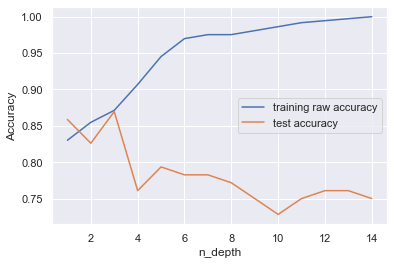

In [46]:
#hyperparameter tunning (one parameter only):

max_depth = range(1,15)
test = []
train = []

for depth in max_depth:
    model = DecisionTreeClassifier(max_depth = depth)
    model.fit(x_train, y_train)
    test.append(model.score(x_test,y_test))
    train.append(model.score(x_train, y_train))
    
# we quickly see overfitting properties
plt.plot(max_depth, train, label="training raw accuracy")
plt.plot(max_depth, test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth")
plt.legend()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

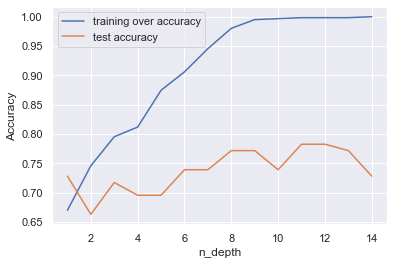

In [47]:
##### OVERSAMPLED
max_depth = range(1,15)
test = []
train = []

for depth in max_depth:
    model = DecisionTreeClassifier(max_depth = depth)
    model.fit(x_train_over, y_train_over)
    test.append(model.score(x_test,y_test))
    train.append(model.score(x_train_over, y_train_over))
    
# we quickly see overfitting properties
plt.plot(max_depth, train, label="training over accuracy")
plt.plot(max_depth, test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth")
plt.legend()
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

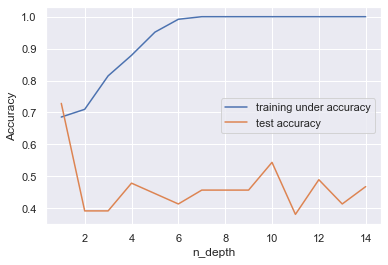

In [48]:
##### UNDERSAMPLED
max_depth = range(1,15)
test = []
train = []

for depth in max_depth:
    model = DecisionTreeClassifier(max_depth= depth)
    model.fit(x_train_under, y_train_under)
    test.append(model.score(x_test,y_test))
    train.append(model.score(x_train_under, y_train_under))
    
# we quickly see overfitting properties
plt.plot(max_depth, train, label="training under accuracy")
plt.plot(max_depth, test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth")
plt.legend()
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

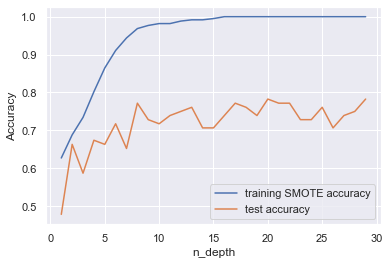

In [49]:
##### SMOTE
max_depth = range(1,30)
test = []
train = []

for depth in max_depth:
    model = DecisionTreeClassifier(max_depth= depth)
    model.fit(x_train_SMOTE, y_train_SMOTE)
    test.append(model.score(x_test,y_test))
    train.append(model.score(x_train_SMOTE, y_train_SMOTE))
    
# we quickly see overfitting properties
plt.plot(max_depth, train, label="training SMOTE accuracy")
plt.plot(max_depth, test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth")
plt.legend()
plt.show

In [50]:
tree = DecisionTreeClassifier(max_depth=3)

tree.fit(x_train, y_train)

print("Test data accuracy is",tree.score(x_test,y_test))
print("Train data accuracy is",tree.score(x_train, y_train))

#CLASSIFICATION REPORT
pred = tree.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.8695652173913043
Train data accuracy is 0.8712328767123287
              precision    recall  f1-score   support

      hungry       0.89      0.97      0.93        79
  not_hungry       0.60      0.23      0.33        13

    accuracy                           0.87        92
   macro avg       0.74      0.60      0.63        92
weighted avg       0.84      0.87      0.84        92



In [51]:
##OVERSAMPLED DATA

tree = DecisionTreeClassifier(max_depth=1)

#train our model:
tree.fit(x_train_over,y_train_over)

#score:
print("Test data accuracy is",tree.score(x_test,y_test))
print("Train oversampled data accuracy is", tree.score(x_train_over,y_train_over))

#CLASSIFICATION REPORT
pred = tree.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.7282608695652174
Train oversampled data accuracy is 0.66996699669967
              precision    recall  f1-score   support

      hungry       0.86      0.81      0.84        79
  not_hungry       0.17      0.23      0.19        13

    accuracy                           0.73        92
   macro avg       0.52      0.52      0.52        92
weighted avg       0.77      0.73      0.75        92



In [120]:
##UNDERSAMPLED DATA

tree = DecisionTreeClassifier(max_depth=1)

#train our model:
tree.fit(x_train_under,y_train_under)

#score:
print("Test data accuracy is",tree.score(x_test,y_test))
print("Train undersampled data accuracy is", tree.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = tree.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.7282608695652174
Train undersampled data accuracy is 0.7016129032258065
              precision    recall  f1-score   support

           0       0.17      0.23      0.19        13
           1       0.86      0.81      0.84        79

    accuracy                           0.73        92
   macro avg       0.52      0.52      0.52        92
weighted avg       0.77      0.73      0.75        92



In [55]:
##SMOTE DATA
tree = DecisionTreeClassifier(max_depth=4)

#train our model:
tree.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test data accuracy is",tree.score(x_test,y_test))
print("Train smote data accuracy is", tree.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = tree.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.6739130434782609
Train smote data accuracy is 0.801980198019802
              precision    recall  f1-score   support

      hungry       0.93      0.67      0.78        79
  not_hungry       0.26      0.69      0.37        13

    accuracy                           0.67        92
   macro avg       0.59      0.68      0.58        92
weighted avg       0.83      0.67      0.72        92



## * Random Forests

In [159]:
from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(n_estimators= 100,max_depth= 5)

forest.fit(x_train, y_train)

#overfitting

#score:
print("Test data accuracy is", forest.score(x_test, y_test))
print("Train raw data accuracy is", forest.score(x_train,y_train))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.8586956521739131
Train raw data accuracy is 0.9095890410958904
              precision    recall  f1-score   support

      hungry       0.86      1.00      0.92        79
  not_hungry       0.00      0.00      0.00        13

    accuracy                           0.86        92
   macro avg       0.43      0.50      0.46        92
weighted avg       0.74      0.86      0.79        92



In [57]:
##OVERSAMPLED DATA
forest=RandomForestClassifier(n_estimators= 100,max_depth= 5)
#train our model:
forest.fit(x_train_over,y_train_over)

#score:
print("Test data accuracy is", forest.score(x_test, y_test))
print("Train oversampled data accuracy is", forest.score(x_train_over,y_train_over))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.8152173913043478
Train oversampled data accuracy is 0.9818481848184818
              precision    recall  f1-score   support

      hungry       0.89      0.90      0.89        79
  not_hungry       0.33      0.31      0.32        13

    accuracy                           0.82        92
   macro avg       0.61      0.60      0.61        92
weighted avg       0.81      0.82      0.81        92



In [166]:
##UNDERSAMPLED DATA

forest_under=RandomForestClassifier(n_estimators= 11,max_depth= 18)

#train our model:
forest_under.fit(x_train_under,y_train_under)

#score:
print("Test data accuracy is", forest_under.score(x_test, y_test))
print("Train undersampled data accuracy is", forest_under.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = forest_under.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.532608695652174
Train undersampled data accuracy is 0.967741935483871
              precision    recall  f1-score   support

      hungry       0.91      0.51      0.65        79
  not_hungry       0.19      0.69      0.30        13

    accuracy                           0.53        92
   macro avg       0.55      0.60      0.47        92
weighted avg       0.81      0.53      0.60        92



In [59]:
##SMOTE DATA

#train our model:
forest.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test data accuracy is", forest.score(x_test, y_test))
print("Train smote data accuracy is", forest.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.6956521739130435
Train smote data accuracy is 0.9389438943894389
              precision    recall  f1-score   support

      hungry       0.90      0.72      0.80        79
  not_hungry       0.24      0.54      0.33        13

    accuracy                           0.70        92
   macro avg       0.57      0.63      0.57        92
weighted avg       0.81      0.70      0.74        92



In [161]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100)]

max_depth = [int(x) for x in np.linspace(1, 50)]

random_grid={"n_estimators":n_estimators,"max_depth":max_depth}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=forest,param_distributions=random_grid,cv=5,n_iter=10)

random_search.fit(x_train_under,y_train_under)

random_search.best_params_

{'n_estimators': 55, 'max_depth': 16}

In [162]:
forest=RandomForestClassifier(n_estimators = 55 ,max_depth= 16)

forest.fit(x_train_under,y_train_under)


#overfitting

#score:
print("Test raw data accuracy is", forest.score(x_test, y_test))
print("Train raw data accuracy is", forest.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.6195652173913043
Train raw data accuracy is 1.0
              precision    recall  f1-score   support

      hungry       0.88      0.65      0.74        79
  not_hungry       0.18      0.46      0.26        13

    accuracy                           0.62        92
   macro avg       0.53      0.55      0.50        92
weighted avg       0.78      0.62      0.68        92



## SVM

In [67]:
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter=10000)
svm.fit(x_train,y_train)

#score:
print("Test raw data accuracy is", svm.score(x_test, y_test))
print("Train raw data accuracy is", svm.score(x_train,y_train))

#CLASSIFICATION REPORT
pred = svm.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.8478260869565217
Train raw data accuracy is 0.8301369863013699
              precision    recall  f1-score   support

      hungry       0.87      0.97      0.92        79
  not_hungry       0.33      0.08      0.12        13

    accuracy                           0.85        92
   macro avg       0.60      0.53      0.52        92
weighted avg       0.79      0.85      0.80        92



In [68]:
##OVERSAMPLED DATA

#train our model:
svm.fit(x_train_over,y_train_over)

#score:
print("Test raw data accuracy is", svm.score(x_test, y_test))
print("Train oversampled data accuracy is", svm.score(x_train_over,y_train_over))

#CLASSIFICATION REPORT
pred = svm.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.3695652173913043
Train oversampled data accuracy is 0.6056105610561056
              precision    recall  f1-score   support

      hungry       0.86      0.32      0.46        79
  not_hungry       0.14      0.69      0.24        13

    accuracy                           0.37        92
   macro avg       0.50      0.50      0.35        92
weighted avg       0.76      0.37      0.43        92



In [69]:
##UNDERSAMPLED DATA

#train our model:
svm.fit(x_train_under,y_train_under)

#score:
print("Test raw data accuracy is", svm.score(x_test, y_test))
print("Train undersampled data accuracy is", svm.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = svm.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.8043478260869565
Train undersampled data accuracy is 0.5403225806451613
              precision    recall  f1-score   support

      hungry       0.86      0.92      0.89        79
  not_hungry       0.14      0.08      0.10        13

    accuracy                           0.80        92
   macro avg       0.50      0.50      0.50        92
weighted avg       0.76      0.80      0.78        92



In [70]:
##SMOTE DATA

#train our model:
svm.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test raw data accuracy is", svm.score(x_test, y_test))
print("Train smote data accuracy is", svm.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = svm.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.6304347826086957
Train smote data accuracy is 0.7145214521452146
              precision    recall  f1-score   support

      hungry       0.88      0.66      0.75        79
  not_hungry       0.18      0.46      0.26        13

    accuracy                           0.63        92
   macro avg       0.53      0.56      0.51        92
weighted avg       0.78      0.63      0.68        92



## Logistic Regression

In [71]:
##RAW DATA

from sklearn.linear_model import LogisticRegression

#initialize model:

log_model = LogisticRegression(max_iter=10000) #max_iter=10000

#train our model:
log_model.fit(x_train,y_train)

#score:
print("Test raw data accuracy is", log_model.score(x_test, y_test))
print("Train raw data accuracy is", log_model.score(x_train,y_train))

#CLASSIFICATION REPORT
pred = log_model.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.8260869565217391
Train raw data accuracy is 0.8465753424657534
              precision    recall  f1-score   support

      hungry       0.87      0.94      0.90        79
  not_hungry       0.29      0.15      0.20        13

    accuracy                           0.83        92
   macro avg       0.58      0.55      0.55        92
weighted avg       0.79      0.83      0.80        92



In [72]:
##OVERSAMPLED DATA

#train our model:
log_model.fit(x_train_over,y_train_over)

#score:
print("Test raw data accuracy is", log_model.score(x_test, y_test))
print("Train oversampled data accuracy is", log_model.score(x_train_over,y_train_over))

#CLASSIFICATION REPORT
pred = log_model.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.6521739130434783
Train oversampled data accuracy is 0.740924092409241
              precision    recall  f1-score   support

      hungry       0.89      0.68      0.77        79
  not_hungry       0.19      0.46      0.27        13

    accuracy                           0.65        92
   macro avg       0.54      0.57      0.52        92
weighted avg       0.79      0.65      0.70        92



In [73]:
##UNDERSAMPLED DATA

#train our model:
log_model.fit(x_train_under,y_train_under)

#score:
print("Test raw data accuracy is", log_model.score(x_test, y_test))
print("Train undersampled data accuracy is", log_model.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = log_model.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.5434782608695652
Train undersampled data accuracy is 0.7903225806451613
              precision    recall  f1-score   support

      hungry       0.88      0.54      0.67        79
  not_hungry       0.16      0.54      0.25        13

    accuracy                           0.54        92
   macro avg       0.52      0.54      0.46        92
weighted avg       0.78      0.54      0.61        92



In [74]:
##SMOTE DATA

#train our model:
log_model.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test raw data accuracy is", log_model.score(x_test, y_test))
print("Train smote data accuracy is", log_model.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = log_model.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.6304347826086957
Train smote data accuracy is 0.7211221122112211
              precision    recall  f1-score   support

      hungry       0.87      0.67      0.76        79
  not_hungry       0.16      0.38      0.23        13

    accuracy                           0.63        92
   macro avg       0.52      0.53      0.49        92
weighted avg       0.77      0.63      0.68        92



## BOOSTING

### ADA Boosting

In [75]:
from sklearn.ensemble import AdaBoostClassifier
ada_class = AdaBoostClassifier(tree,n_estimators=100)

ada_class.fit(x_train,y_train)


#score:
print("Test  data accuracy is", ada_class.score(x_test, y_test))
print("Train raw data accuracy is", ada_class.score(x_train,y_train))

#CLASSIFICATION REPORT
pred = ada_class.predict(x_test)
print(classification_report(y_test, pred))

Test  data accuracy is 0.8586956521739131
Train raw data accuracy is 1.0
              precision    recall  f1-score   support

      hungry       0.87      0.99      0.92        79
  not_hungry       0.50      0.08      0.13        13

    accuracy                           0.86        92
   macro avg       0.68      0.53      0.53        92
weighted avg       0.81      0.86      0.81        92



In [76]:
##OVERSAMPLED DATA

#train our model:
ada_class.fit(x_train_over,y_train_over)

#score:
print("Test  data accuracy is", ada_class.score(x_test, y_test))
print("Train oversampled data accuracy is", ada_class.score(x_train_over,y_train_over))

#CLASSIFICATION REPORT
pred = ada_class.predict(x_test)
print(classification_report(y_test, pred))

Test  data accuracy is 0.8478260869565217
Train oversampled data accuracy is 1.0
              precision    recall  f1-score   support

      hungry       0.86      0.99      0.92        79
  not_hungry       0.00      0.00      0.00        13

    accuracy                           0.85        92
   macro avg       0.43      0.49      0.46        92
weighted avg       0.74      0.85      0.79        92



In [77]:
tree = DecisionTreeClassifier(max_depth=4)
ada_class = AdaBoostClassifier(tree,n_estimators=100)

In [83]:
##UNDERSAMPLED DATA
tree = DecisionTreeClassifier(max_depth=3)
ada_class = AdaBoostClassifier(tree,n_estimators=47)
#train our model:
ada_class.fit(x_train_under,y_train_under)

#score:
print("Test  data accuracy is", ada_class.score(x_test, y_test))
print("Train undersampled data accuracy is", ada_class.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = ada_class.predict(x_test)
print(classification_report(y_test, pred))

Test  data accuracy is 0.532608695652174
Train undersampled data accuracy is 1.0
              precision    recall  f1-score   support

      hungry       0.88      0.53      0.66        79
  not_hungry       0.16      0.54      0.25        13

    accuracy                           0.53        92
   macro avg       0.52      0.54      0.45        92
weighted avg       0.77      0.53      0.60        92



In [81]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100)]
max_depth = [int(x) for x in np.linspace(1, 100)]
random_grid={"n_estimators":n_estimators}#,"max_depth":max_depth}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=ada_class,param_distributions=random_grid,cv=5,n_iter=10)

random_search.fit(x_train_under,y_train_under)

random_search.best_params_

{'n_estimators': 87}

In [84]:
##SMOTE DATA

#train our model:
ada_class.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test  data accuracy is", ada_class.score(x_test, y_test))
print("Train smote data accuracy is", ada_class.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = ada_class.predict(x_test)
print(classification_report(y_test, pred))

Test  data accuracy is 0.7282608695652174
Train smote data accuracy is 1.0
              precision    recall  f1-score   support

      hungry       0.88      0.80      0.83        79
  not_hungry       0.20      0.31      0.24        13

    accuracy                           0.73        92
   macro avg       0.54      0.55      0.54        92
weighted avg       0.78      0.73      0.75        92



### Gradient Boosting

In [85]:
from sklearn.ensemble import GradientBoostingClassifier
gb_class = GradientBoostingClassifier(max_depth=5, n_estimators=100)

gb_class.fit(x_train, y_train)


#score:
print("Test raw data accuracy is", gb_class.score(x_test, y_test))
print("Train raw data accuracy is", gb_class.score(x_train,y_train))

#CLASSIFICATION REPORT
pred = gb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.8586956521739131
Train raw data accuracy is 1.0
              precision    recall  f1-score   support

      hungry       0.88      0.96      0.92        79
  not_hungry       0.50      0.23      0.32        13

    accuracy                           0.86        92
   macro avg       0.69      0.60      0.62        92
weighted avg       0.83      0.86      0.84        92



In [86]:
##OVERSAMPLED DATA
gb_class = GradientBoostingClassifier(max_depth=5, n_estimators=100)
#train our model:
gb_class.fit(x_train_over,y_train_over)

#score:
print("Test raw data accuracy is", gb_class.score(x_test, y_test))
print("Train oversampled data accuracy is", gb_class.score(x_train_over,y_train_over))

#CLASSIFICATION REPORT
pred = gb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.8043478260869565
Train oversampled data accuracy is 1.0
              precision    recall  f1-score   support

      hungry       0.86      0.92      0.89        79
  not_hungry       0.14      0.08      0.10        13

    accuracy                           0.80        92
   macro avg       0.50      0.50      0.50        92
weighted avg       0.76      0.80      0.78        92



In [87]:
##UNDERSAMPLED DATA
gb_class = GradientBoostingClassifier(max_depth=7, n_estimators=32)
#train our model:
gb_class.fit(x_train_under,y_train_under)

#score:
print("Test raw data accuracy is", gb_class.score(x_test, y_test))
print("Train undersampled data accuracy is", gb_class.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = gb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.4673913043478261
Train undersampled data accuracy is 1.0
              precision    recall  f1-score   support

      hungry       0.84      0.47      0.60        79
  not_hungry       0.12      0.46      0.20        13

    accuracy                           0.47        92
   macro avg       0.48      0.46      0.40        92
weighted avg       0.74      0.47      0.54        92



In [89]:
##UNDERSAMPLED DATA
gb_class = GradientBoostingClassifier(max_depth=4, n_estimators=63)
#train our model:
gb_class.fit(x_train_under,y_train_under)

#score:
print("Test raw data accuracy is", gb_class.score(x_test, y_test))
print("Train undersampled data accuracy is", gb_class.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = gb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.5652173913043478
Train undersampled data accuracy is 1.0
              precision    recall  f1-score   support

      hungry       0.90      0.56      0.69        79
  not_hungry       0.19      0.62      0.29        13

    accuracy                           0.57        92
   macro avg       0.54      0.59      0.49        92
weighted avg       0.80      0.57      0.63        92



In [88]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100)]
max_depth = [int(x) for x in np.linspace(1, 50)]
random_grid={"n_estimators":n_estimators,"max_depth":max_depth}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=gb_class,param_distributions=random_grid,cv=5,n_iter=10)

random_search.fit(x_train_under,y_train_under)

random_search.best_params_

{'n_estimators': 63, 'max_depth': 4}

In [90]:
##SMOTE DATA
gb_class = GradientBoostingClassifier(max_depth=5, n_estimators=100)
#train our model:
gb_class.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test raw data accuracy is", gb_class.score(x_test, y_test))
print("Train smote data accuracy is", gb_class.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = gb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.8152173913043478
Train smote data accuracy is 1.0
              precision    recall  f1-score   support

      hungry       0.90      0.89      0.89        79
  not_hungry       0.36      0.38      0.37        13

    accuracy                           0.82        92
   macro avg       0.63      0.64      0.63        92
weighted avg       0.82      0.82      0.82        92



### Extreme Gradient Boosting

In [91]:
audio_features_nothungry.head()


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,category
0,-499.424713,112.081161,-49.807816,-18.214211,13.028866,-26.151291,-14.420481,7.603708,-11.387850,-9.128422,...,-2.046124,3.276306,4.814387,1.566615,0.335952,1.693973,-0.683485,-4.242712,-2.821082,not_hungry
1,-503.240997,155.624619,-53.089634,-9.338754,18.954021,-30.361124,-10.490327,-0.191979,-25.778471,-7.877410,...,-1.159282,-5.115259,-1.217770,0.125908,-1.005656,0.573103,1.187626,3.673102,5.454000,not_hungry
2,-426.707062,157.331879,-52.705971,-14.524200,11.352674,-37.552837,-15.138313,0.320166,-24.708115,-10.134473,...,-1.795501,-2.781284,-0.339015,-0.960696,-2.035474,-0.726631,-2.245474,-2.666178,-0.223122,not_hungry
3,-389.038696,168.445236,-67.223183,-17.126297,13.631199,-41.452286,-14.523580,-1.005277,-31.239029,-8.384931,...,2.486675,0.891681,3.970485,1.110400,-1.227667,0.690895,-1.282442,-0.621609,2.109241,not_hungry
4,-317.432892,176.035706,-62.427364,-4.467136,17.833765,-48.702011,-19.136120,-3.011306,-32.136478,-8.081997,...,2.126175,1.675153,5.267370,0.063184,-1.355639,2.513359,-0.295119,-0.607795,1.403075,not_hungry


In [92]:
# Converting hungry in 1 and not hungry in 0:
audio_features_0 = audio_features_nothungry.copy()

#define the replacement values as a dictionary

replace_map = {'hungry': 1, 'not_hungry': 0}

# replace the values in the 'color' column
audio_features_0['category'] = audio_features_0['category'].replace(replace_map)

#audio_features_nothungry[audio_features_nothungry["category"] == 1]

audio_features_0.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,category
0,-499.424713,112.081161,-49.807816,-18.214211,13.028866,-26.151291,-14.420481,7.603708,-11.387850,-9.128422,...,-2.046124,3.276306,4.814387,1.566615,0.335952,1.693973,-0.683485,-4.242712,-2.821082,0
1,-503.240997,155.624619,-53.089634,-9.338754,18.954021,-30.361124,-10.490327,-0.191979,-25.778471,-7.877410,...,-1.159282,-5.115259,-1.217770,0.125908,-1.005656,0.573103,1.187626,3.673102,5.454000,0
2,-426.707062,157.331879,-52.705971,-14.524200,11.352674,-37.552837,-15.138313,0.320166,-24.708115,-10.134473,...,-1.795501,-2.781284,-0.339015,-0.960696,-2.035474,-0.726631,-2.245474,-2.666178,-0.223122,0
3,-389.038696,168.445236,-67.223183,-17.126297,13.631199,-41.452286,-14.523580,-1.005277,-31.239029,-8.384931,...,2.486675,0.891681,3.970485,1.110400,-1.227667,0.690895,-1.282442,-0.621609,2.109241,0
4,-317.432892,176.035706,-62.427364,-4.467136,17.833765,-48.702011,-19.136120,-3.011306,-32.136478,-8.081997,...,2.126175,1.675153,5.267370,0.063184,-1.355639,2.513359,-0.295119,-0.607795,1.403075,0


In [93]:
### Split the dataset into independent and dependent dataset
x = audio_features_0.drop('category', axis=1)
y = audio_features_0['category']

In [94]:
### Train Test Split
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [95]:
train = pd.concat([x_train, y_train], axis=1)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,category
141,-258.423950,239.174896,-3.597260,8.841642,31.073893,-16.249443,0.903809,11.036634,-18.024740,-4.845502,...,-2.531755,-5.525385,-3.534909,-4.060783,-5.719588,-2.922280,-2.325560,-3.443725,-2.434219,1
293,-355.442352,124.710594,-52.769253,-34.160305,4.574441,-22.938278,-17.212320,-1.698827,-9.802575,-0.844767,...,3.440170,2.412681,1.027842,1.208941,-0.125557,-1.442946,-2.517964,-2.875237,-1.660491,1
49,-265.649139,134.414963,-96.223511,-19.944441,13.617352,-42.273296,4.097267,17.961351,-28.440102,-2.451402,...,1.767201,0.373891,1.227304,-0.757722,-1.193614,-0.384385,-3.710185,-2.369870,1.663185,0
52,-523.431824,137.423218,-18.293631,0.016314,18.337383,-21.331781,-9.218897,9.865731,-9.552913,-7.619267,...,-3.237782,-4.885705,-3.987910,-2.569896,-3.619754,-2.978716,-2.323520,-3.452256,-2.452348,1
74,-255.786163,167.835861,-100.291290,3.766301,24.010281,-60.293919,-2.762302,17.007700,-27.183031,2.805851,...,-1.883172,0.049351,4.547917,-0.952618,0.363429,3.148814,-1.890258,-0.916096,1.869166,1


In [96]:
train.shape

(365, 41)

##### OVERSAMPLING

In [97]:
# old sample sizes:

train_hungry = train[train["category"] == 1]
train_nothungry = train[train["category"] == 0]


print(train_hungry.shape)
print(train_nothungry.shape)

(303, 41)
(62, 41)


In [98]:
train_nothungry_over = resample(train_nothungry, # <--- undersample from here
                                   replace = True, # <--- we need replacement since we don't have enough datapoints
                                   n_samples=len(train_hungry))# <--- make both sets the same size

In [99]:
train_over = pd.concat([train_hungry, train_nothungry_over])
print(train_over.shape)
train_over.head()

(606, 41)


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,category
141,-258.423950,239.174896,-3.597260,8.841642,31.073893,-16.249443,0.903809,11.036634,-18.024740,-4.845502,...,-2.531755,-5.525385,-3.534909,-4.060783,-5.719588,-2.922280,-2.325560,-3.443725,-2.434219,1
293,-355.442352,124.710594,-52.769253,-34.160305,4.574441,-22.938278,-17.212320,-1.698827,-9.802575,-0.844767,...,3.440170,2.412681,1.027842,1.208941,-0.125557,-1.442946,-2.517964,-2.875237,-1.660491,1
52,-523.431824,137.423218,-18.293631,0.016314,18.337383,-21.331781,-9.218897,9.865731,-9.552913,-7.619267,...,-3.237782,-4.885705,-3.987910,-2.569896,-3.619754,-2.978716,-2.323520,-3.452256,-2.452348,1
74,-255.786163,167.835861,-100.291290,3.766301,24.010281,-60.293919,-2.762302,17.007700,-27.183031,2.805851,...,-1.883172,0.049351,4.547917,-0.952618,0.363429,3.148814,-1.890258,-0.916096,1.869166,1
295,-323.106140,107.602089,-38.831306,-25.561359,-5.242953,-33.480370,-14.614306,9.044759,-6.424458,-4.776411,...,4.065837,5.763697,2.614671,0.447468,-0.253474,-2.133288,-4.075959,-2.455865,-0.160012,1


In [100]:
#seperating features from label again 

x_train_over = train_over.drop("category", axis=1)
y_train_over = train_over["category"]

#### UNDERSAMPLING

In [101]:
train_hungry_under = resample(train_hungry, # <--- undersample from here
                                   replace = False, # <--- we don't need replacement since we have enough datapoints
                                   n_samples=len(train_nothungry))# <--- make both sets the same size

In [102]:
train_under = pd.concat([train_hungry_under, train_nothungry])
print(train_under.shape)
train_under.head()

(124, 41)


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,category
367,-330.203369,129.915314,-103.650986,-25.724098,27.992052,-36.013630,-15.077555,19.388964,-2.287765,2.513568,...,1.892492,-0.076363,2.577709,1.699322,-0.412275,0.904868,0.906336,-0.330228,-0.918968,1
413,-393.551544,67.035973,-30.993271,-1.692643,6.050554,-25.064146,-6.302704,6.518375,-10.327528,-4.434161,...,-2.177753,-1.341726,4.389815,0.955591,-1.476831,2.984613,-1.092628,-6.347181,0.753410,1
312,-383.245544,104.968918,-65.016296,-12.415621,11.528188,-31.175743,-6.237650,1.908418,-20.316397,1.742686,...,-2.151196,-0.363495,1.655588,-1.617085,-1.609652,0.819842,-1.840646,-2.643400,0.124556,1
393,-245.321136,146.859665,-87.047813,-12.271175,24.398317,-30.594849,7.513073,14.628478,-30.956602,-5.762622,...,1.627369,-2.924653,1.874588,2.736259,1.151827,2.471841,2.293869,2.161129,-0.146583,1
58,-364.895844,80.195671,-35.093002,-14.971576,6.184248,-16.126644,-4.589623,6.591949,-9.353189,-8.968859,...,-0.939787,-2.245137,-0.347123,0.734760,1.156361,1.497194,1.526564,2.461107,1.221293,1


In [103]:
#seperating features from label again 

x_train_under = train_under.drop("category", axis=1)
y_train_under = train_under["category"]

#### SMOTE

In [104]:
from imblearn.over_sampling import SMOTE

# initialize SMOTE function:
#sm = SMOTE(sampling_strategy={'belly_pain': len("hungry")}) #sampling_strategy == ratio = 1
smote = SMOTE()


# using SMOTE model to give us a balanced x_train and y_train:
x_train_SMOTE, y_train_SMOTE = smote.fit_resample(x_train, y_train)

#for the minority class, SMOTE will create new datapoints based on kkn models 
# so that the x_train and y_train end up with the same lenght

#### ** MODEL

In [105]:
import xgboost

xgb_class=xgboost.XGBClassifier(n_estimators=10,max_depth=5)

xgb_class.fit(x_train,y_train)
xgb_class.score(x_test,y_test)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train raw data accuracy is", xgb_class.score(x_train,y_train))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.8695652173913043
Train raw data accuracy is 0.9698630136986301
              precision    recall  f1-score   support

           0       0.67      0.15      0.25        13
           1       0.88      0.99      0.93        79

    accuracy                           0.87        92
   macro avg       0.77      0.57      0.59        92
weighted avg       0.85      0.87      0.83        92



In [ ]:
## random grid

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100)]
max_depth = [int(x) for x in np.linspace(1, 50)]
random_grid={"n_estimators":n_estimators,"max_depth":max_depth}

random_search = RandomizedSearchCV(estimator=xgb_class,param_distributions=random_grid,cv=5,n_iter=10)

random_search.fit(x_train, y_train)

random_search.best_params_

In [ ]:

xgb_class=xgboost.XGBClassifier(n_estimators=43,max_depth=43)

xgb_class.fit(x_train,y_train)
xgb_class.score(x_test,y_test)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train raw data accuracy is", xgb_class.score(x_train,y_train))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

In [106]:
##OVERSAMPLED DATA

xgb_class=xgboost.XGBClassifier(n_estimators=83,max_depth=7)

#train our model:
xgb_class.fit(x_train_over,y_train_over)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train oversampled data accuracy is", xgb_class.score(x_train_over,y_train_over))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.8586956521739131
Train oversampled data accuracy is 1.0
              precision    recall  f1-score   support

           0       0.50      0.23      0.32        13
           1       0.88      0.96      0.92        79

    accuracy                           0.86        92
   macro avg       0.69      0.60      0.62        92
weighted avg       0.83      0.86      0.84        92



In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100)]
max_depth = [int(x) for x in np.linspace(1, 50)]
random_grid={"n_estimators":n_estimators,"max_depth":max_depth}

random_search = RandomizedSearchCV(estimator=xgb_class,param_distributions=random_grid,cv=5,n_iter=10)

random_search.fit(x_train_over,y_train_over)

random_search.best_params_

In [107]:
##UNDERSAMPLED DATA
xgb_class=xgboost.XGBClassifier(n_estimators=10,max_depth=5)

#train our model:
xgb_class.fit(x_train_under,y_train_under)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train undersampled data accuracy is", xgb_class.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.5869565217391305
Train undersampled data accuracy is 1.0
              precision    recall  f1-score   support

           0       0.14      0.38      0.21        13
           1       0.86      0.62      0.72        79

    accuracy                           0.59        92
   macro avg       0.50      0.50      0.46        92
weighted avg       0.76      0.59      0.65        92



In [108]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100)]
max_depth = [int(x) for x in np.linspace(1, 50)]
random_grid={"n_estimators":n_estimators,"max_depth":max_depth}

random_search = RandomizedSearchCV(estimator=xgb_class,param_distributions=random_grid,cv=5,n_iter=10)

random_search.fit(x_train_under,y_train_under)

random_search.best_params_

{'n_estimators': 3, 'max_depth': 49}

In [109]:
##UNDERSAMPLED DATA
xgb_class=xgboost.XGBClassifier(n_estimators=3,max_depth=49)

#train our model:
xgb_class.fit(x_train_under,y_train_under)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train undersampled data accuracy is", xgb_class.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.6195652173913043
Train undersampled data accuracy is 0.9274193548387096
              precision    recall  f1-score   support

           0       0.18      0.46      0.26        13
           1       0.88      0.65      0.74        79

    accuracy                           0.62        92
   macro avg       0.53      0.55      0.50        92
weighted avg       0.78      0.62      0.68        92



In [110]:
##UNDERSAMPLED DATA
xgb_class=xgboost.XGBClassifier(n_estimators=25,max_depth=39)

#train our model:
xgb_class.fit(x_train_under,y_train_under)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train undersampled data accuracy is", xgb_class.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.5978260869565217
Train undersampled data accuracy is 1.0
              precision    recall  f1-score   support

           0       0.17      0.46      0.24        13
           1       0.88      0.62      0.73        79

    accuracy                           0.60        92
   macro avg       0.52      0.54      0.49        92
weighted avg       0.77      0.60      0.66        92



In [111]:
##SMOTE DATA
xgb_class=xgboost.XGBClassifier(n_estimators=10,max_depth=5)

#train our model:
xgb_class.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train smote data accuracy is", xgb_class.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.782608695652174
Train smote data accuracy is 0.9884488448844885
              precision    recall  f1-score   support

           0       0.32      0.46      0.37        13
           1       0.90      0.84      0.87        79

    accuracy                           0.78        92
   macro avg       0.61      0.65      0.62        92
weighted avg       0.82      0.78      0.80        92



In [112]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100)]
max_depth = [int(x) for x in np.linspace(1, 50)]
random_grid={"n_estimators":n_estimators,"max_depth":max_depth}

random_search = RandomizedSearchCV(estimator=xgb_class,param_distributions=random_grid,cv=5,n_iter=10)

random_search.fit(x_train_SMOTE, y_train_SMOTE)

random_search.best_params_

{'n_estimators': 65, 'max_depth': 5}

In [113]:
##SMOTE DATA
xgb_class=xgboost.XGBClassifier(n_estimators=65,max_depth=5)

#train our model:
xgb_class.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train smote data accuracy is", xgb_class.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.7934782608695652
Train smote data accuracy is 1.0
              precision    recall  f1-score   support

           0       0.33      0.46      0.39        13
           1       0.91      0.85      0.88        79

    accuracy                           0.79        92
   macro avg       0.62      0.65      0.63        92
weighted avg       0.82      0.79      0.81        92



## Final Model

In [207]:
##UNDERSAMPLED DATA

forest_under=RandomForestClassifier(n_estimators= 11,max_depth= 18)

#train our model:
forest_under.fit(x_train_under,y_train_under)

#score:
print("Test data accuracy is", forest_under.score(x_test, y_test))
print("Train undersampled data accuracy is", forest_under.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = forest_under.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.5869565217391305
Train undersampled data accuracy is 0.9919354838709677
              precision    recall  f1-score   support

      hungry       0.92      0.57      0.70        79
  not_hungry       0.21      0.69      0.32        13

    accuracy                           0.59        92
   macro avg       0.56      0.63      0.51        92
weighted avg       0.82      0.59      0.65        92



In [211]:
audio_file = 'C:/Users/migue/Documents/IRONHACK/FINAL PROJECT/audio_files/eea17285-4ab9-4d34-a2f5-55fc8c866ac6-1431887695278-1.7-f-26-ti.wav'
audio_file
array_audio = features_extractor(audio_file).reshape(1, -1)

In [208]:
import pickle
pickle.dump(forest_under, open("forest_model.p", "wb"))

In [209]:
forest_under_1 = pickle.load(open("forest_model.p", "rb"))
forest_under_1

RandomForestClassifier(max_depth=18, n_estimators=11)

In [212]:
test_audio = array_audio.reshape(1, -1)
array_audio = features_extractor(audio_file).reshape(1, -1)
forest_under_1.predict(array_audio)

array(['not_hungry'], dtype=object)